<a href="https://colab.research.google.com/github/EmaanWasay/IAI600-Labs/blob/main/Lab_6_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Title: Unsupervised Learning Using K-Means Clustering on California Housing Data

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is recommended
import sklearn
# (skip strict assert to avoid breaking older environments; uncomment if you want)
# assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures in Jupyter
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures (optional)
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning_california_housing"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id, "->", path)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [ ]:
from sklearn.datasets import fetch_california_housing

# Load dataset as a pandas DataFrame
housing = fetch_california_housing(as_frame=True)
df = housing.frame.copy()

# The dataset columns: ['MedInc', 'HouseAge', 'AveRooms', ... , 'Latitude', 'Longitude', 'MedHouseVal']
# We will use Longitude, Latitude, MedInc (median income) for clustering.
# Note: column names here are 'MedInc', 'HouseAge', ... ; but dataset provides 'Longitude' and 'Latitude'
# create a small DataFrame with the desired features
X = df[['Longitude', 'Latitude', 'MedInc']].copy()

# quick look
X.head()


,Longitude,Latitude,MedInc
0,-122.23,37.88,8.3252
1,-122.22,37.86,8.3014
2,-122.24,37.85,7.2574
3,-122.25,37.85,5.6431
4,-122.25,37.85,3.8462


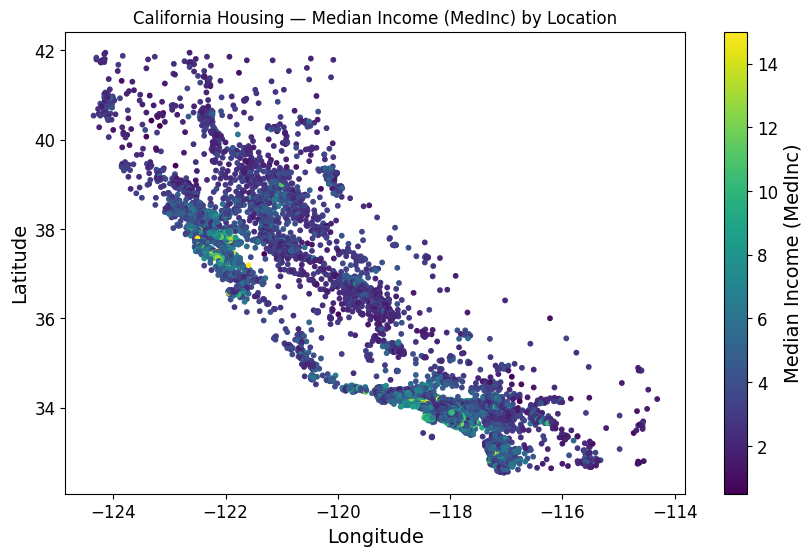

In [ ]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(X['Longitude'], X['Latitude'], c=X['MedInc'], s=10)
plt.colorbar(sc, label="Median Income (MedInc)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("California Housing — Median Income (MedInc) by Location")
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

# We scale all three features before clustering so MedInc doesn't dominate due to scale differences.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# For convenience keep a DataFrame view of scaled features
X_scaled_df = pd.DataFrame(X_scaled, columns=['Longitude_scaled', 'Latitude_scaled', 'MedInc_scaled'])
X_scaled_df.head()


,Longitude_scaled,Latitude_scaled,MedInc_scaled
0,-1.327835,1.052548,2.344766
1,-1.322844,1.043185,2.332238
2,-1.332827,1.038503,1.782699
3,-1.337818,1.038503,0.932968
4,-1.337818,1.038503,-0.012881


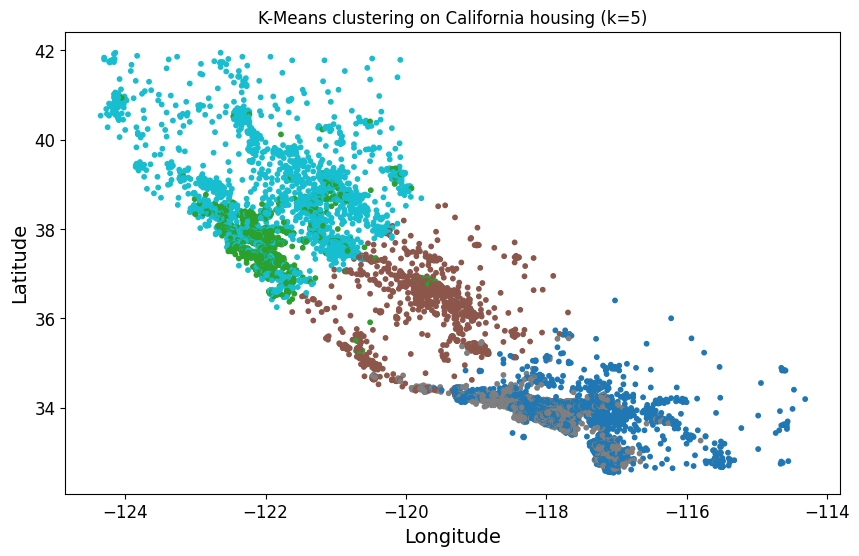

In [ ]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
clusters_k5 = kmeans.fit_predict(X_scaled)

# Attach clusters to original df for plotting & analysis
df['Cluster_KMeans_k5'] = clusters_k5

plt.figure(figsize=(10, 6))
plt.scatter(df['Longitude'], df['Latitude'], c=df['Cluster_KMeans_k5'], cmap='tab10', s=10)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"K-Means clustering on California housing (k={k})")
plt.show()


k=2 -> silhouette score = 0.5482
k=3 -> silhouette score = 0.5180
k=4 -> silhouette score = 0.4352
k=5 -> silhouette score = 0.4101
k=6 -> silhouette score = 0.3985
k=7 -> silhouette score = 0.3723
k=8 -> silhouette score = 0.3667
k=9 -> silhouette score = 0.3462
k=10 -> silhouette score = 0.3537


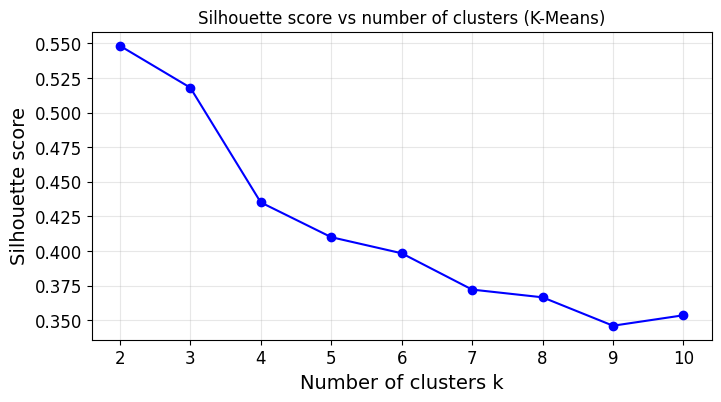

Best k by silhouette score: 2


In [ ]:
from sklearn.metrics import silhouette_score

sil_scores = []
k_values = list(range(2, 11))

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)
    print(f"k={k} -> silhouette score = {score:.4f}")

plt.figure(figsize=(8,4))
plt.plot(k_values, sil_scores, "bo-")
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette score")
plt.title("Silhouette score vs number of clusters (K-Means)")
plt.xticks(k_values)
plt.grid(alpha=0.3)
plt.show()

best_k = k_values[int(np.argmax(sil_scores))]
print("Best k by silhouette score:", best_k)


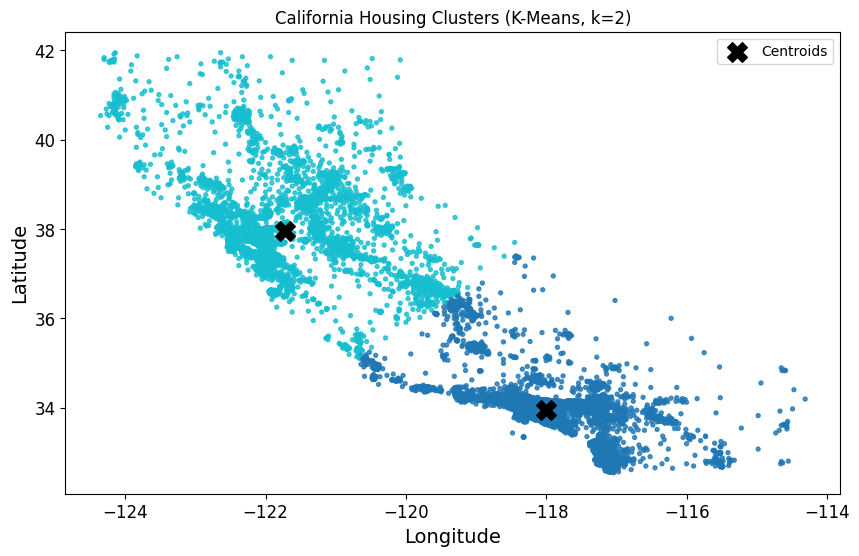

In [ ]:
# Fit final KMeans using best_k
kmeans_best = KMeans(n_clusters=best_k, random_state=42)
labels_best = kmeans_best.fit_predict(X_scaled)
df['Cluster_KMeans_best'] = labels_best

# To plot centers on original longitude/latitude coords:
# transform cluster centers back to original scale (inverse transform)
centers_scaled = kmeans_best.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)

plt.figure(figsize=(10,6))
plt.scatter(df['Longitude'], df['Latitude'], c=df['Cluster_KMeans_best'], cmap='tab10', s=8, alpha=0.8)
plt.scatter(centers_original[:,0], centers_original[:,1], marker='X', s=200, color='black', label='Centroids')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"California Housing Clusters (K-Means, k={best_k})")
plt.legend()
plt.show()


In [ ]:
cluster_summary = df.groupby('Cluster_KMeans_best')['MedInc'].agg(['count','mean','median']).sort_index()
cluster_summary = cluster_summary.rename(columns={'count':'n_points','mean':'mean_MedInc','median':'median_MedInc'})
cluster_summary


,n_points,mean_MedInc,median_MedInc
Cluster_KMeans_best,,,
0,11937,3.922444,3.5882
1,8703,3.799659,3.4620


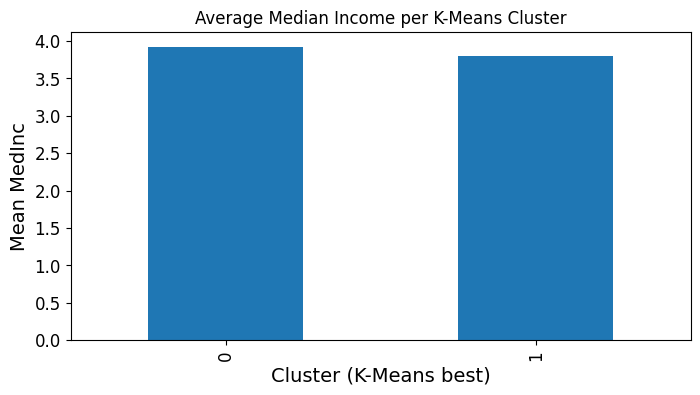

<Figure size 1000x500 with 0 Axes>

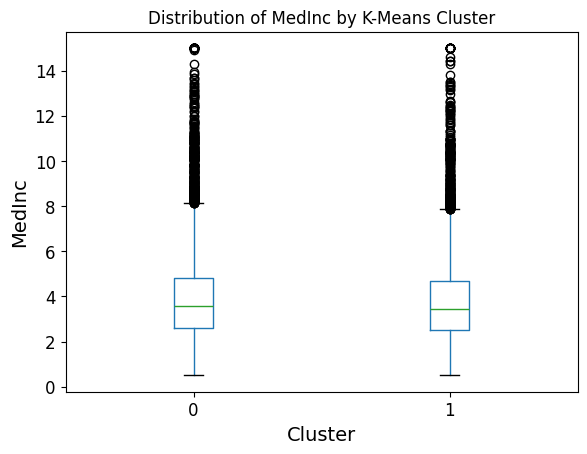

In [ ]:
plt.figure(figsize=(8,4))
cluster_summary['mean_MedInc'].plot(kind='bar')
plt.xlabel("Cluster (K-Means best)")
plt.ylabel("Mean MedInc")
plt.title("Average Median Income per K-Means Cluster")
plt.show()

# Boxplot to show distribution of MedInc per cluster
plt.figure(figsize=(10,5))
df.boxplot(column='MedInc', by='Cluster_KMeans_best', grid=False)
plt.title("Distribution of MedInc by K-Means Cluster")
plt.suptitle("")  # remove default title
plt.xlabel("Cluster")
plt.ylabel("MedInc")
plt.show()


DBSCAN clusters found (excluding noise): 5
DBSCAN noise points count: 170


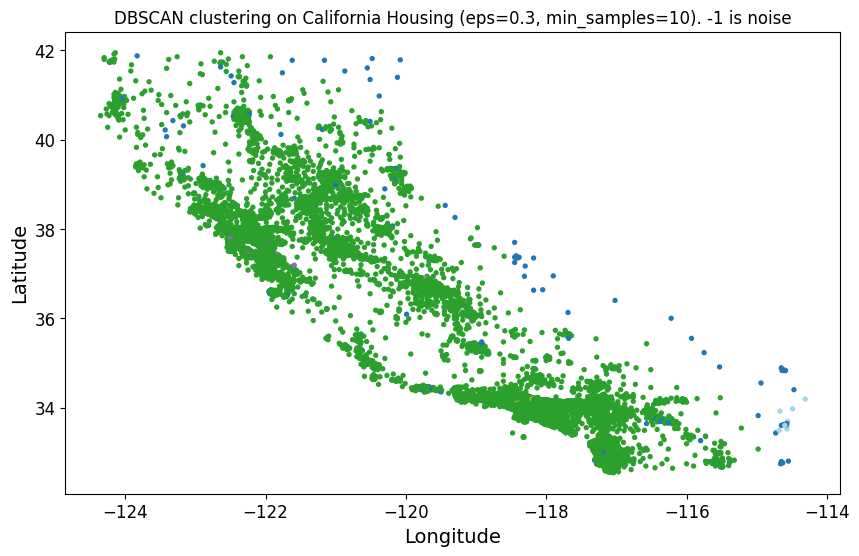

In [ ]:
from sklearn.cluster import DBSCAN

# DBSCAN works on scaled features
# eps & min_samples may require tuning; eps=0.3 is a reasonable start when data is scaled.
dbscan = DBSCAN(eps=0.3, min_samples=10)
db_labels = dbscan.fit_predict(X_scaled)

df['Cluster_DBSCAN'] = db_labels

# Count clusters found (-1 is noise)
n_dbscan_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
print("DBSCAN clusters found (excluding noise):", n_dbscan_clusters)
print("DBSCAN noise points count:", np.sum(db_labels == -1))

plt.figure(figsize=(10,6))
plt.scatter(df['Longitude'], df['Latitude'], c=df['Cluster_DBSCAN'], cmap='tab20', s=8)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN clustering on California Housing (eps=0.3, min_samples=10). -1 is noise")
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score

# Silhouette for K-Means (already used in selection)
sil_kmeans = silhouette_score(X_scaled, df['Cluster_KMeans_best'])
print("Silhouette score (K-Means best_k):", sil_kmeans)

# For DBSCAN, silhouette can be computed only excluding noise (-1) and if there are at least 2 clusters
mask_core = df['Cluster_DBSCAN'] != -1
db_unique_clusters = set(df['Cluster_DBSCAN'][mask_core])
if len(db_unique_clusters) >= 2:
    sil_dbscan = silhouette_score(X_scaled[mask_core], df['Cluster_DBSCAN'][mask_core])
    print("Silhouette score (DBSCAN, excluding noise):", sil_dbscan)
else:
    sil_dbscan = None
    print("DBSCAN didn't find enough clusters for silhouette score (excluding noise).")


Silhouette score (K-Means best_k): 0.5482304452184799
Silhouette score (DBSCAN, excluding noise): -0.0060314669684288


In [ ]:
# Save cluster labels into a CSV for further analysis (optional)
out_df = df[['Longitude','Latitude','MedInc','Cluster_KMeans_best','Cluster_DBSCAN']]
out_df.to_csv("california_housing_clusters_summary.csv", index=False)
print("Saved summary to california_housing_clusters_summary.csv")

# Quick final summary print
print("\n--- Final summary ---")
print(f"K-Means best k by silhouette: {best_k}")
print("K-Means cluster sizes:")
print(df['Cluster_KMeans_best'].value_counts().sort_index())
print("\nDBSCAN cluster sizes (including -1 noise label):")
print(df['Cluster_DBSCAN'].value_counts().sort_index())


Saved summary to california_housing_clusters_summary.csv

--- Final summary ---
K-Means best k by silhouette: 2
K-Means cluster sizes:
Cluster_KMeans_best
0    11937
1     8703
Name: count, dtype: int64

DBSCAN cluster sizes (including -1 noise label):
Cluster_DBSCAN
-1      170
 0    20401
 1       16
 2        7
 3       36
 4       10
Name: count, dtype: int64
